# Download Dataset

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip
!git clone https://github.com/gasvn/Res2Net.git
!pip install ipython-autotime

--2020-11-08 11:41:45--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  19.5MB/s    in 27s     

2020-11-08 11:42:12 (11.8 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]

Archive:  UCMerced_LandUse.zip
   creating: UCMerced_LandUse/Images/
   creating: UCMerced_LandUse/Images/agricultural/
  inflating: UCMerced_LandUse/Images/agricultural/agricultural00.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural02.tif  
  inflating: UCMerced_LandUse/Images/agricultural/agricultural03.tif  
  inflating: UCMerced_LandUs

# Import Libraries


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision import utils
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
from PIL import Image
from keras.utils import to_categorical 
import os
import math
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sb
import matplotlib.pyplot as plt

from IPython.display import clear_output
from google.colab import files

from Res2Net import res2net

%load_ext autotime

time: 110 µs


# Define Dataset

In [ ]:
BASE_PATH = "./UCMerced_LandUse/Images"
CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda") if CUDA else torch.device("cpu")
BATCH_SIZE = 10
CLASSES = 21
LEARNING_RATE = 0.0001
EPOCHS = 60
LABELS = sorted(os.listdir(BASE_PATH))
LABEL_DICT = { LABELS[index] : index for index in range(CLASSES) }

time: 87.4 ms


In [ ]:
image_files = []
image_labels = []

for folder in LABELS:
  class_image_path = os.path.join(BASE_PATH, folder)
  image_files += [os.path.join(class_image_path, image) for image in os.listdir(class_image_path)]
  image_labels += [LABEL_DICT[folder]] * len(os.listdir(class_image_path))


time: 15.1 ms


In [ ]:
class UCMDataset(Dataset):
  def __init__(self, image_paths, image_labels, transform=None):
    self.image_paths = image_paths
    self.image_labels = image_labels
    self.transform = transform

  def __len__(self):
    return len(self.image_labels)

  def __getitem__(self, index):
    image = np.array(Image.open(self.image_paths[index]))
    label = self.image_labels[index]

    data = {'image':image, 'label':label}

    if self.transform:
      data = self.transform(data)

    return data

time: 10.3 ms


In [ ]:
class ProcessTrainImage(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.Resize(size=(256, 256)),                                          
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(degrees=90),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample


time: 8.79 ms


In [ ]:
class ProcessTestImage(object):
  def __call__(self, sample):
    image_transformations = transforms.Compose([
                                          transforms.ToPILImage(),
                                          transforms.Resize((256, 256)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]
                                              )
                                          ])

    image, label = sample['image'], sample['label']
    transformed_image = image_transformations(image)
    transformed_label = to_categorical(label, num_classes=CLASSES)

    transformed_sample = {
        'image': transformed_image,
        'label': transformed_label
    }
    return transformed_sample


time: 8.99 ms


In [ ]:
def create_train_test_loaders(batch_size, train_index, test_index):
  train_images = list(map(image_files.__getitem__, train_index))
  train_labels = list(map(image_labels.__getitem__, train_index))

  test_images = list(map(image_files.__getitem__, test_index))
  test_labels = list(map(image_labels.__getitem__, test_index))

  train_set = UCMDataset(train_images, train_labels, transform=ProcessTrainImage())
  test_set = UCMDataset(test_images, test_labels, transform=ProcessTestImage())

  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

time: 7.85 ms


# Define Pretrained Models

In [ ]:
def freeze_params(parameters):
  for param in parameters:
    param.requires_grad = False

time: 1.69 ms


In [ ]:
def unfreeze_params(parameters):
  for param in parameters:
    param.requires_grad = True

time: 2.46 ms


In [ ]:
def transfer_model(pretrained_model, layers_to_train):
  model = pretrained_model(pretrained=True)

  model.fc = nn.Linear(model.fc.in_features, CLASSES)
  
  freeze_params(model.parameters())

  if layers_to_train=="last_layer":
    params = model.fc.parameters()
  
  if layers_to_train=="all":
    params = model.parameters()
  
  unfreeze_params(params)

  return model.to(DEVICE)

time: 8.97 ms


In [ ]:
def pretrained_res2net50_14w_8s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_14w_8s, layers_to_train)
  return model

time: 1.96 ms


In [ ]:
def pretrained_res2net50_26w_4s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_4s, layers_to_train)
  return model

time: 1.27 ms


In [ ]:
def pretrained_res2net50_26w_6s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_6s, layers_to_train)
  return model

time: 1.59 ms


In [ ]:
def pretrained_res2net50_26w_8s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_26w_8s, layers_to_train)
  return model

time: 1.57 ms


In [ ]:
def pretrained_res2net50_48w_2s(layers_to_train="all"):
  model = transfer_model(res2net.res2net50_48w_2s, layers_to_train)
  return model

time: 3.11 ms


In [ ]:
def pretrained_resnet50(layers_to_train="all"):
  model = transfer_model(models.resnet50, layers_to_train)
  return model

time: 2.09 ms


In [ ]:
all_models = {
    'resnet50' : pretrained_resnet50,    
    'res2net50_14w_8s' : pretrained_res2net50_14w_8s,
    'res2net50_26w_4s' : pretrained_res2net50_26w_4s,
    'res2net50_26w_6s' : pretrained_res2net50_26w_6s,
    'res2net50_26w_8s' : pretrained_res2net50_26w_8s,
    'res2net50_48w_2s' : pretrained_res2net50_48w_2s
}

time: 8.76 ms


In [ ]:
#summary(all_models['res2net101_26w_4s'](), (3, 256, 256))

time: 582 µs


# Train Model

In [ ]:
def test_model(model, test_loader, criterion, device):
  test_accuracy = 0
  test_loss = 0
  true_labels = []
  pred_labels = []

  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()

      test_accuracy += sum(correct)
      test_loss += batch_loss.item() * image_batch.size(0)

      true_labels += list(label_batch.cpu().numpy())
      pred_labels += list(output_labels.cpu().numpy())

  average_testing_loss = test_loss / len(test_loader.sampler)
  average_testing_accuracy = test_accuracy / len(test_loader.sampler)

  return average_testing_loss, average_testing_accuracy, true_labels, pred_labels

time: 17.9 ms


In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, device, save_path):
  min_train_loss = np.inf

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(epochs):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch in train_loader:
      image_batch = batch['image'].to(device)
      label_batch = batch['label'].to(device)
      _, label_batch = torch.max(label_batch, 1)

      optimizer.zero_grad()
      y_pred = model(image_batch)
      batch_loss = criterion(y_pred, label_batch)
      batch_loss.backward()
      optimizer.step()

      _, output_labels = torch.max(y_pred, 1)
      correct = label_batch.eq(output_labels).cpu().numpy()
      train_accuracy += sum(correct)
      train_loss += batch_loss.item() * image_batch.size(0)

    average_training_loss = train_loss / len(train_loader.sampler)
    average_training_accuracy = train_accuracy / len(train_loader.sampler)

    average_testing_loss, average_testing_accuracy, _, _ = test_model(
        model, test_loader, 
        criterion, device
        )    
    
    train_losses.append(average_training_loss)
    test_losses.append(average_testing_loss)
    train_accuracies.append(average_training_accuracy)
    test_accuracies.append(average_testing_accuracy)

    print('Epoch: {} \t Train Loss: {:.6f} \t Test Loss: {:.6f} \t Train Accuracy: {:.4f} \t Test Accuracy: {:.4f}'.format(epoch, average_training_loss, average_testing_loss, average_training_accuracy, average_testing_accuracy))
    
    if min_train_loss > average_training_loss :
      print('Model improved - Saving Model')
      min_train_loss = average_training_loss
      torch.save(model.state_dict(), save_path)      
  
  return train_losses, test_losses, train_accuracies, test_accuracies


time: 69.6 ms


In [ ]:
def random_seed():
  torch.manual_seed(0)
  np.random.seed(0)
  random.seed(0)

  if CUDA:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

time: 5.22 ms


In [ ]:
FOLDS = []

skfolds = StratifiedKFold(n_splits=5)
skfolds.get_n_splits(image_files, image_labels)

for train_index, test_index in skfolds.split(image_files, image_labels):
  FOLDS.append((train_index, test_index))

time: 22.3 ms


In [ ]:
LAYERS_TO_TRAIN = 'last_layer'
fold = 0
model_name  = 'res2net50_48w_2s'

for train_index, test_index in FOLDS:
  random_seed()
  train_loader, test_loader = create_train_test_loaders(BATCH_SIZE, train_index, test_index)
  
  model = all_models[model_name](LAYERS_TO_TRAIN) 

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

  save_path = model_name + '_weights_' + LAYERS_TO_TRAIN + '_fold_' + str(fold) + '.pt'

  train_losses, test_losses, train_accuracies, test_accuracies = train_model(
      model=model, 
      train_loader=train_loader, 
      test_loader=test_loader, 
      optimizer=optimizer, 
      criterion=criterion, 
      epochs=EPOCHS, 
      device=DEVICE,
      save_path=save_path
      )
  
  fold += 1
  clear_output(wait=True)

time: 1h 9min 12s


# Validation and Visualization

In [ ]:
def save_results(average_testing_accuracy, c_report, filename):
  if not os.path.exists("Results"):
    os.makedirs("Results")

  filename = os.path.join("Results", filename)

  with open(filename, 'w') as x_file:
    x_file.write('Test accuracy - ' + str(average_testing_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('Classification report : \n')
    x_file.write(str(c_report))
    x_file.write('\n')


time: 6.43 ms


In [ ]:
def plot_confusion_matrix(y_true, y_pred, filename):
  sb.set(font_scale=1.5)

  if not os.path.exists("Figures"):
    os.makedirs("Figures")

  filename = os.path.join("Figures", filename)
  
  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(16, 14))
  sb.heatmap(cm, annot=True, fmt="d", linewidths=5, xticklabels=LABELS, yticklabels=LABELS)

  plt.savefig(filename)
  plt.show()

time: 6.8 ms


Confusion matrix for fold0


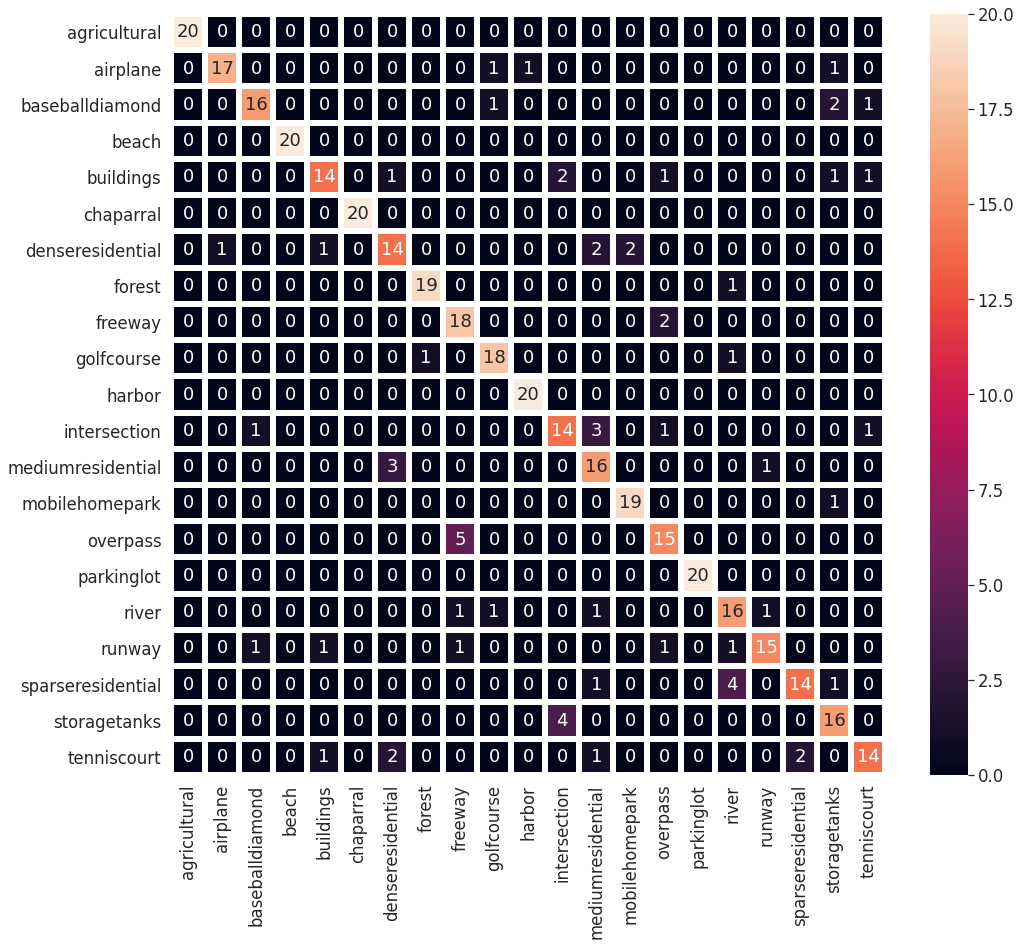


Confusion matrix for fold1


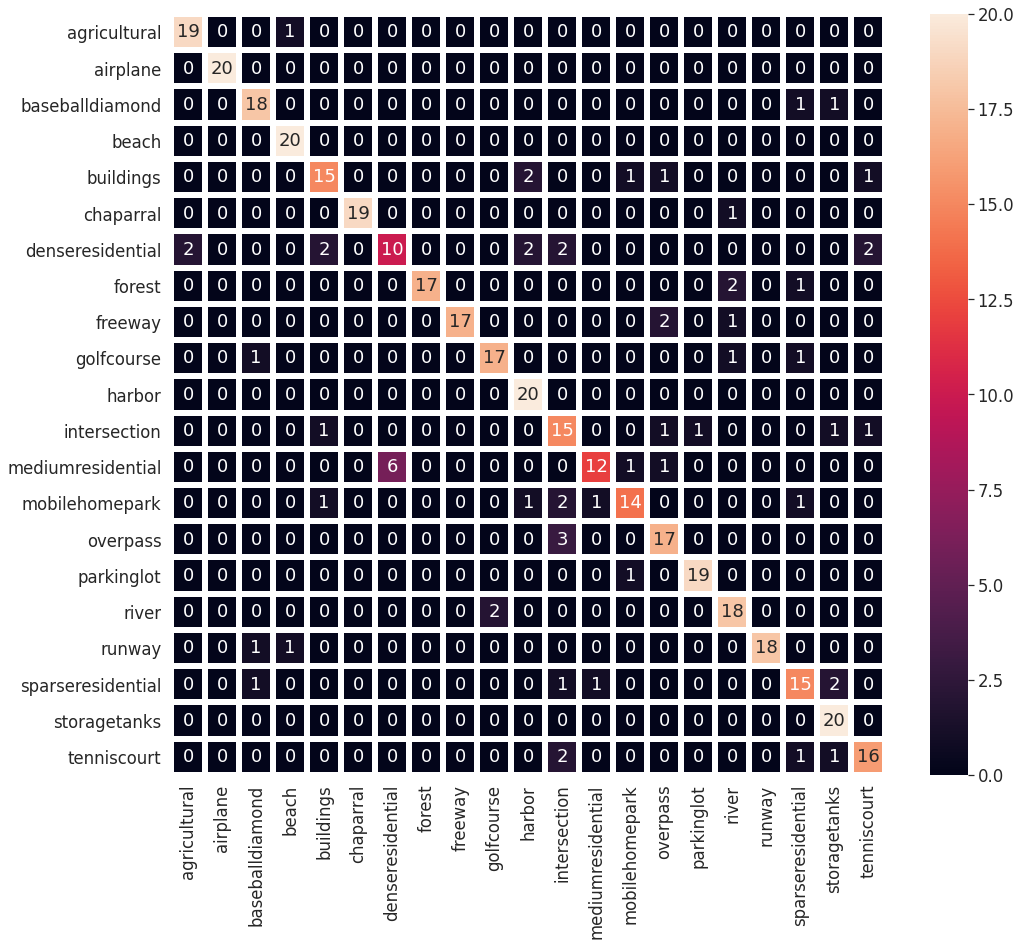


Confusion matrix for fold2


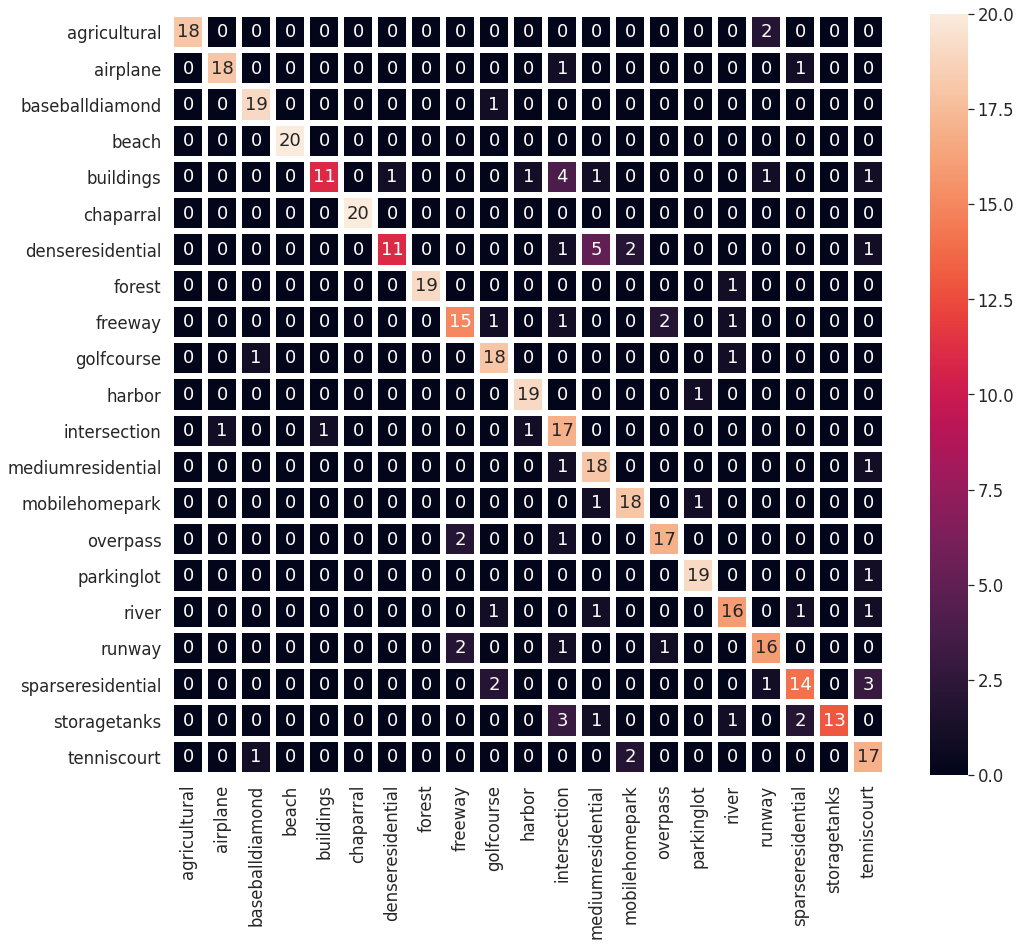


Confusion matrix for fold3


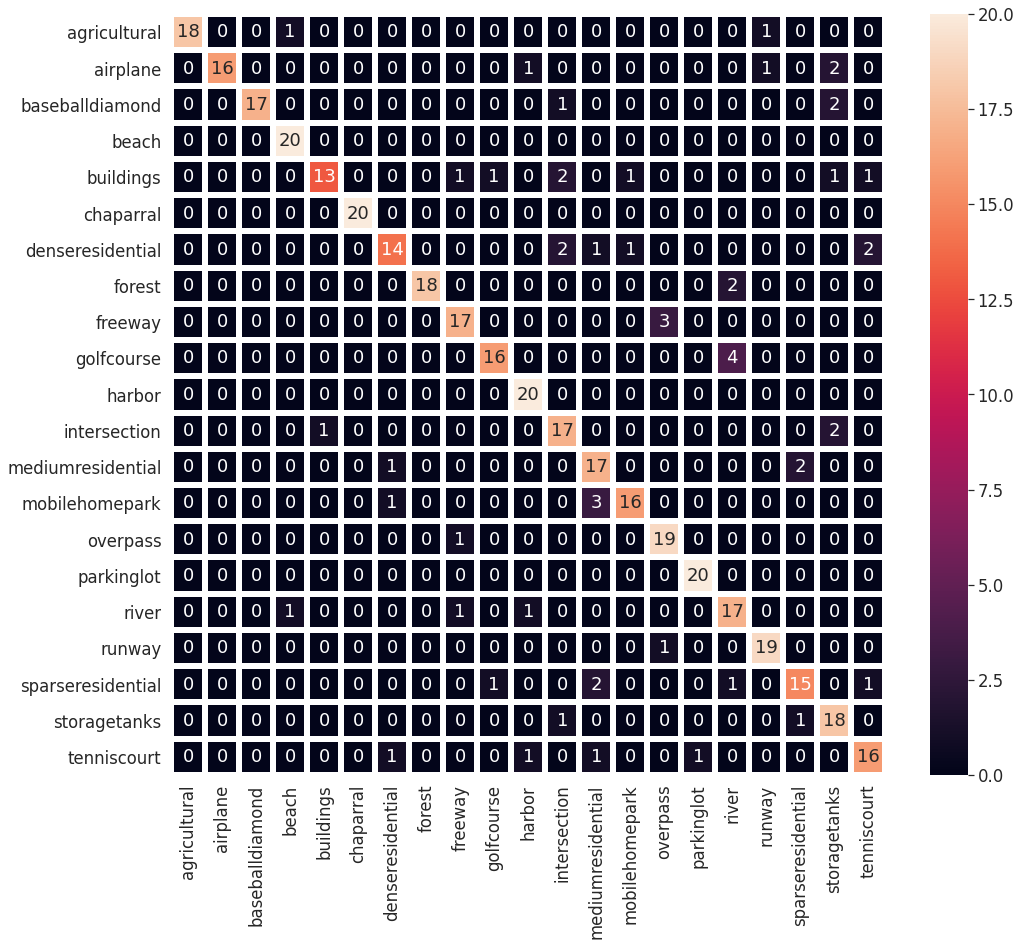


Confusion matrix for fold4


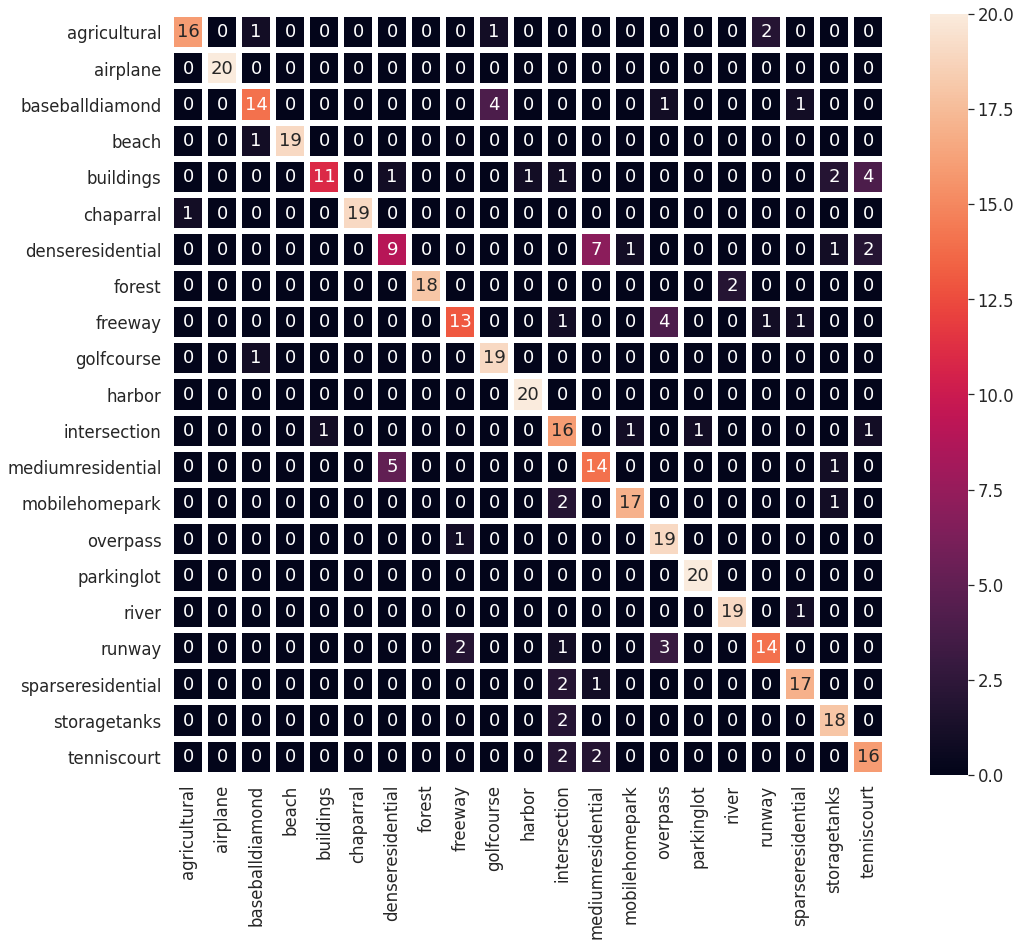


time: 31 s


In [ ]:
fold = 0

for train_index, test_index in FOLDS:
  _, test_loader = create_train_test_loaders(BATCH_SIZE, train_index, test_index)  
  model = all_models[model_name](LAYERS_TO_TRAIN)

  save_path = model_name + '_weights_' + LAYERS_TO_TRAIN + '_fold_' + str(fold) + '.pt'
  model.load_state_dict(torch.load(save_path))

  average_testing_loss, average_testing_accuracy, y_true, y_pred = test_model(
      model=model, 
      test_loader=test_loader, 
      criterion=criterion, 
      device=DEVICE
      )
  
  c_report = classification_report(y_true, y_pred, digits=4, target_names=LABELS)
  filename = model_name + '_weights_' + LAYERS_TO_TRAIN + '_fold_' + str(fold) + '.txt'
  save_results(average_testing_accuracy, c_report, filename)

  print("Confusion matrix for fold" + str(fold))
  filename = model_name + '_weights_' + LAYERS_TO_TRAIN + '_fold_' + str(fold) + '.png'
  plot_confusion_matrix(y_true, y_pred, filename)
  print("")
  
  fold += 1